############################## $\textbf{Patrick L. Mthisi}$ (Patrickmthisi@hotmail.com)##########################
# Project description and objectives:
The data for this project was obtained from: https://www.kaggle.com/datasets/shenba/time-series-datasets/data.
The dataset contains monthly electricity production. The data shows systematic temporal structures such as trends and seasonality. 

Our goal is to $\textbf{provide forecasts of monthly electricity production using ARIMA time series forecasting methods}$.

This notebook demonstrates an end-to-end ARIMA-based time series forecasting project for electricity production, including model fitting, rolling forecasts, and performance evaluation using RMSE. 

The following important time series forecasting concepts are explored in this end-to-end project:
1. ARIMA Modeling: The ARIMA model is implemented for forecasting. It involves the identification of the best ARIMA parameters (p, d, q) through an automated search using historical data.
2. Rolling Forecast: 
    - After fitting the model, a rolling forecast method is implemented where predictions are made one step ahead, and the model is updated with the actual values iteratively.
    - Predictions are corrected using a bias term, which helps adjust the model for errors observed during initial predictions.
3. Model Evaluation:
    - The predicted values are compared against the actual values from the validation set.
    - The Root Mean Squared Error (RMSE) metric is used to evaluate the performance of the model.
    - The final predictions and actual validation data are plotted for visualization.    
4. Next Steps: We also mention possible improvements such as experimenting with power transformations (e.g., BoxCox) for further performance optimization.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
import os
import warnings

# create a differenced time series
def difference(dataset, interval=1):
    diff = []
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - interval]  
        diff.append(value)
    return diff

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


def plot_acf_pacf(dataset, lags):
    plt.figure(figsize=(8.5, 4))
    plt.subplot(211)
    plot_acf(dataset, lags=lags, ax=plt.gca())
    plt.subplot(212)
    plot_pacf(dataset, lags=lags, ax=plt.gca())
    plt.tight_layout()
    plt.show()

# Load Dataset

In [2]:
# load data and save to file
filename = 'Electric_Production.csv'
series = pd.read_csv(filename, header=0, index_col=0, parse_dates=True).squeeze('columns')
print(series.head())
# using the current last 12 months for validation
split_point = len(series) - 13
dataset, validation = series[:split_point], series[split_point:]
# del series
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
data_path = 'electricity_consumption_data'
os.makedirs(f'{data_path}', exist_ok=True)
dataset.to_csv(f'{data_path}/dataset.csv', header=False)
validation.to_csv(f'{data_path}/validation.csv', header=False)

DATE
1985-01-01    72.5052
1985-02-01    70.6720
1985-03-01    62.4502
1985-04-01    57.4714
1985-05-01    55.3151
Name: IPG2211A2N, dtype: float64
Dataset 384, Validation 13


# Persistence Model

In [3]:
# load dataset
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')

# prepare data
X = series.values.astype('float32')
train_size = int(len(X) * 0.9)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
for t in range(len(test)):
    # make prediction
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[t]
    history.append(obs) 
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = root_mean_squared_error(test, predictions)
print('RMSE: %.3f' % rmse)

>Predicted=99.281, Expected=91.787
>Predicted=91.787, Expected=97.285
>Predicted=97.285, Expected=113.473
>Predicted=113.473, Expected=124.255
>Predicted=124.255, Expected=112.881
>Predicted=112.881, Expected=104.763
>Predicted=104.763, Expected=90.287
>Predicted=90.287, Expected=92.134
>Predicted=92.134, Expected=101.878
>Predicted=101.878, Expected=108.550
>Predicted=108.550, Expected=108.194
>Predicted=108.194, Expected=100.417
>Predicted=100.417, Expected=92.384
>Predicted=92.384, Expected=99.703
>Predicted=99.703, Expected=109.348
>Predicted=109.348, Expected=120.270
>Predicted=120.270, Expected=116.379
>Predicted=116.379, Expected=104.471
>Predicted=104.471, Expected=89.746
>Predicted=89.746, Expected=91.093
>Predicted=91.093, Expected=102.649
>Predicted=102.649, Expected=111.635
>Predicted=111.635, Expected=110.592
>Predicted=110.592, Expected=101.920
>Predicted=101.920, Expected=91.596
>Predicted=91.596, Expected=93.063
>Predicted=93.063, Expected=103.220
>Predicted=103.220, Ex

# Data Analysis

In [4]:
class time_series_analysis(object):
    def __init__(self, series, freq):
        self.series = series
        self.freq = freq
        
    def line_plot(self):
        self.series.plot(figsize=(10, 4))
        plt.xlabel('Date')
        plt.ylabel('Monthly Eletricity Production')
        plt.xticks(rotation=0)
        plt.show()
        
    def density_plot(self):
        plt.figure(figsize=(10, 4))
        plt.subplot(211)
        self.series.hist(ax=plt.gca())
        plt.subplot(212)
        self.series.plot(kind='kde', ax=plt.gca())
        plt.show()
        
    def decompose_timeseries(self):
        decomposition_multi = seasonal_decompose(self.series, model='multiplicative', period = 12)
        fig = decomposition_multi.plot()
        fig.set_size_inches((9, 7))
        plt.show()
        
    def box_and_whisker_plot(self):
        groups = self.series.groupby(pd.Grouper(freq=self.freq))
        year_data = {}
        for name, group in groups:
            year_data[name.year] = group.values
        years = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in year_data.items()]))
        years.boxplot(figsize=(10, 4))
        plt.xlabel('Year')
        plt.ylabel('Monthly Eletricity Production')
        plt.xticks(rotation=90)
        plt.show()
        
    def glance_seasonal_pattern(self, start, end):
        groups = self.series[start:end].groupby(pd.Grouper(freq=self.freq))
        plt.figure(figsize=(9, 7))
        i = 1
        n_groups = len(groups)
        for name, group in groups:
            plt.subplot((n_groups * 100) + 10 + i)
            i += 1
            plt.plot(group, color='green', lw=0.75)
        plt.tight_layout()
        plt.show()

In [5]:
tsa = time_series_analysis(series=dataset, freq='YE')

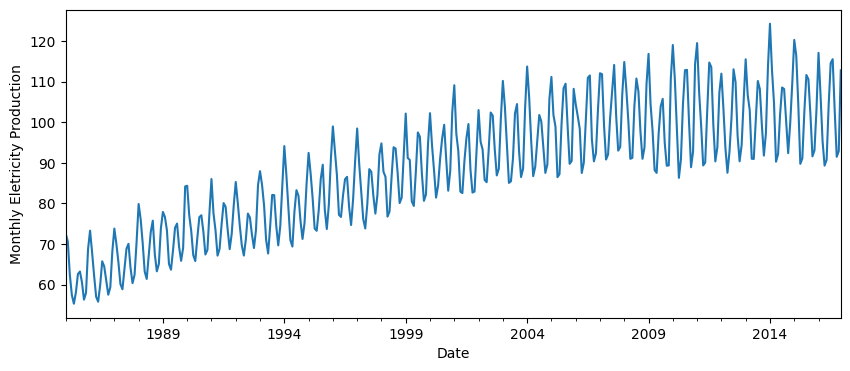

In [6]:
tsa.line_plot()

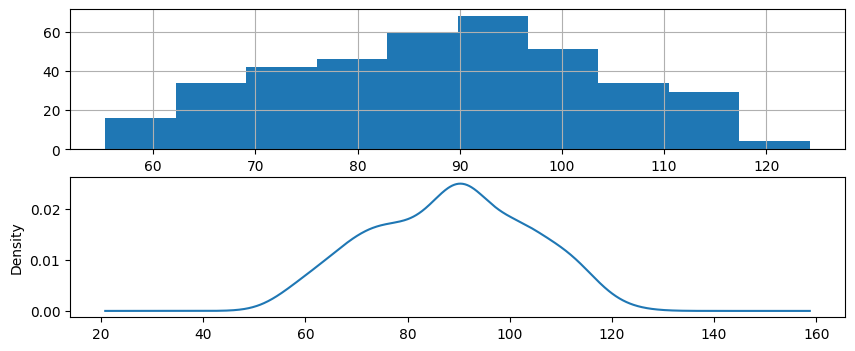

In [7]:
tsa.density_plot()

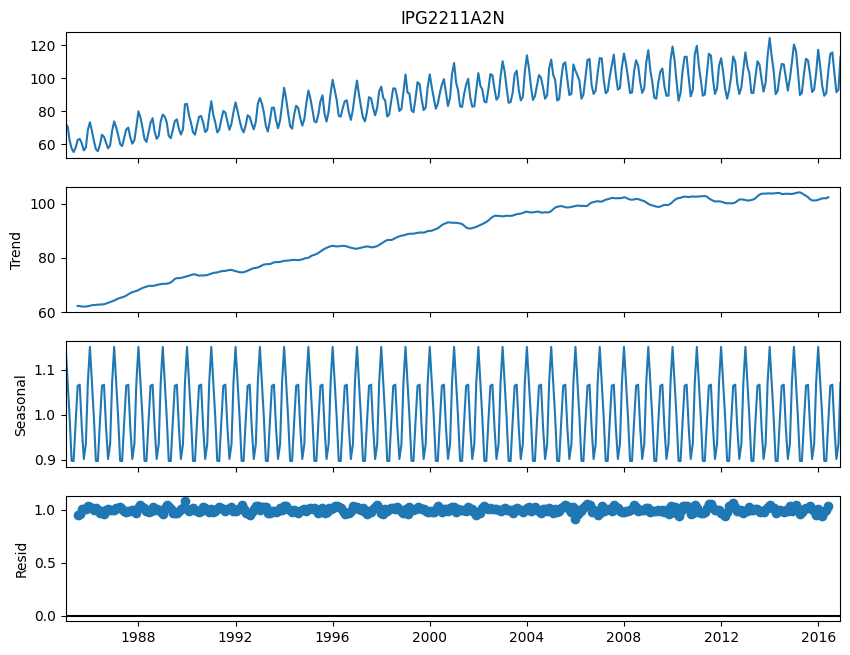

In [8]:
tsa.decompose_timeseries()

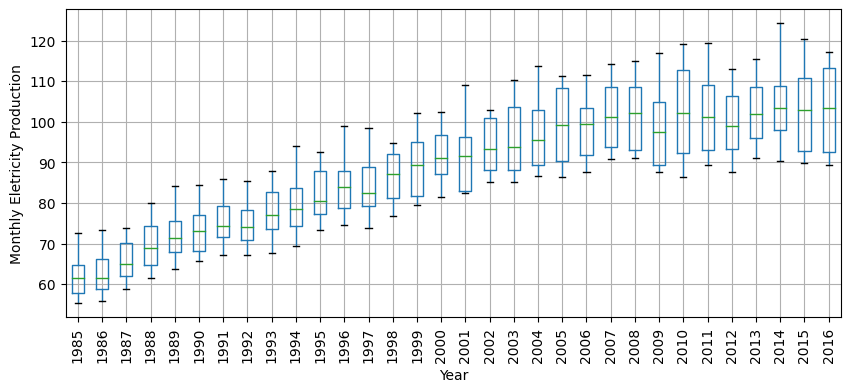

In [9]:
tsa.box_and_whisker_plot()

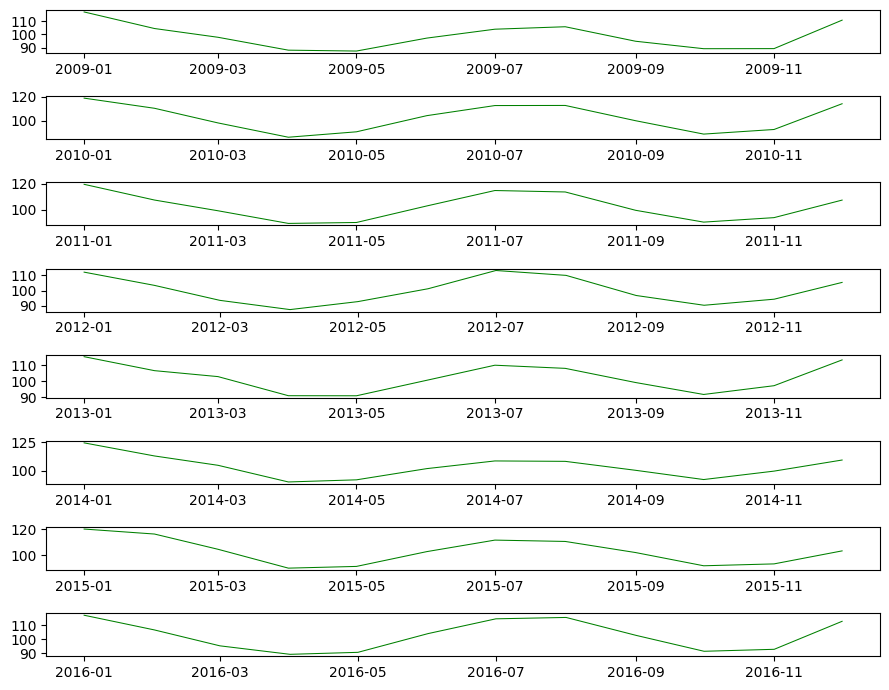

In [10]:
tsa.glance_seasonal_pattern(start='2009', end='2016')

# Data Transformation

ADF Test Statistic: -8.048531
p_value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


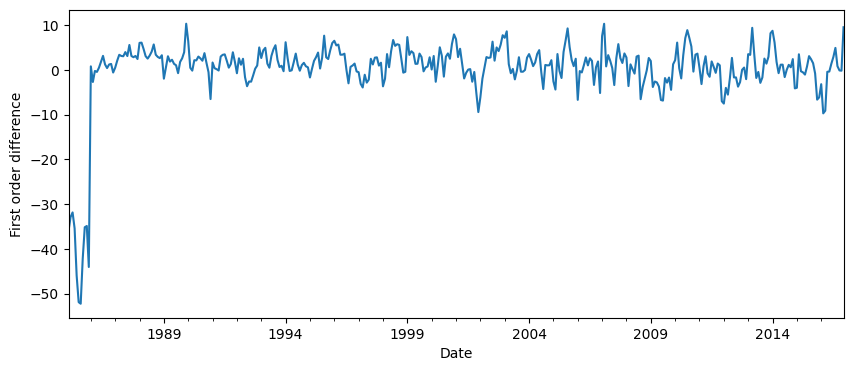

In [11]:
X = series.values.astype('float32')
months_in_year = 12
stationary = difference(X, months_in_year)
stationary = pd.Series(stationary)
stationary.index = series.index[1:]
result = adfuller(stationary)
print('ADF Test Statistic: %f' % result[0])
print('p_value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# save to file
stationary.to_csv(f'{data_path}/stationary', header=False)
# plot 
stationary.plot(figsize=(10, 4))
plt.xlabel('Date')
plt.ylabel('First order difference')
plt.xticks(rotation=0)
plt.show()

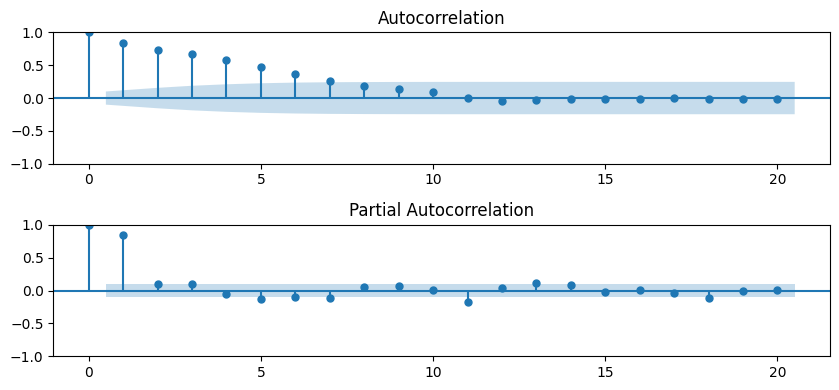

In [12]:
plot_acf_pacf(stationary, lags=20)

# Grid Search ARIMA

In [13]:
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.9)
    train, test = X[0:train_size], X[train_size:]
    # walk-forward validation
    history = [x for x in train]
    months_in_year = 12
    predictions = []
    for t in range(len(test)):
        # transform data
        diff = difference(history, months_in_year)
        # predict
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        # oobservation
        obs = test[t]
        history.append(obs)
    rmse = root_mean_squared_error(test, predictions)
    return rmse
    
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('>ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    np.save(f'{data_path}/best_cfg.npy', best_cfg)
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings('ignore')
# load dataset
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')
evaluate_models(series.values, p_values, d_values, q_values)

>ARIMA(0, 0, 0) RMSE=4.138
>ARIMA(0, 0, 1) RMSE=3.367
>ARIMA(0, 0, 2) RMSE=3.536
>ARIMA(0, 0, 3) RMSE=3.604
>ARIMA(0, 0, 4) RMSE=3.502
>ARIMA(0, 0, 5) RMSE=3.386
>ARIMA(0, 0, 6) RMSE=3.251
>ARIMA(0, 1, 0) RMSE=3.561
>ARIMA(0, 1, 1) RMSE=3.534
>ARIMA(0, 1, 2) RMSE=3.362
>ARIMA(0, 1, 3) RMSE=3.359
>ARIMA(0, 1, 4) RMSE=3.371
>ARIMA(0, 1, 5) RMSE=3.414
>ARIMA(0, 1, 6) RMSE=3.479
>ARIMA(0, 2, 0) RMSE=4.956
>ARIMA(0, 2, 1) RMSE=3.555
>ARIMA(0, 2, 2) RMSE=3.526
>ARIMA(0, 2, 3) RMSE=3.371
>ARIMA(0, 2, 4) RMSE=3.367
>ARIMA(0, 2, 5) RMSE=3.379
>ARIMA(0, 2, 6) RMSE=3.410
>ARIMA(1, 0, 0) RMSE=3.423
>ARIMA(1, 0, 1) RMSE=3.403
>ARIMA(1, 0, 2) RMSE=3.341
>ARIMA(1, 0, 3) RMSE=3.353
>ARIMA(1, 0, 4) RMSE=3.328
>ARIMA(1, 0, 5) RMSE=3.367
>ARIMA(1, 0, 6) RMSE=3.739
>ARIMA(1, 1, 0) RMSE=3.552
>ARIMA(1, 1, 1) RMSE=3.451
>ARIMA(1, 1, 2) RMSE=3.332
>ARIMA(1, 1, 3) RMSE=3.345
>ARIMA(1, 1, 4) RMSE=3.383
>ARIMA(1, 1, 5) RMSE=3.385
>ARIMA(1, 1, 6) RMSE=3.461
>ARIMA(1, 2, 0) RMSE=4.675
>ARIMA(1, 2, 1) RMSE=3.543
>

# Model Diagnostics: Analysing Residuals

               0
count  39.000000
mean    0.400167
std     3.259362
min    -7.799092
25%    -1.387895
50%     0.263635
75%     2.113509
max     8.785703


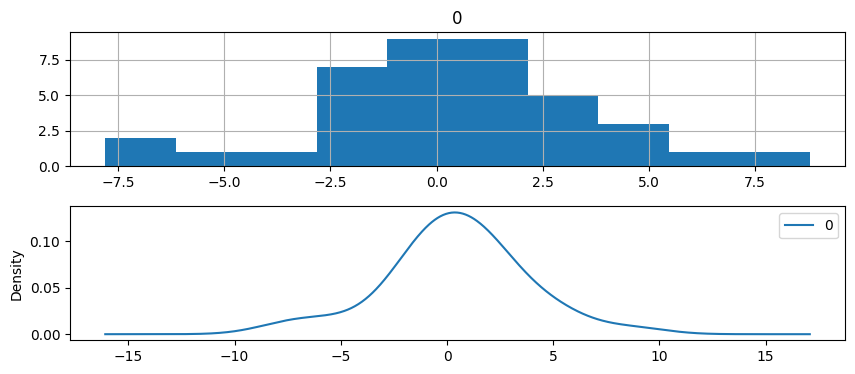

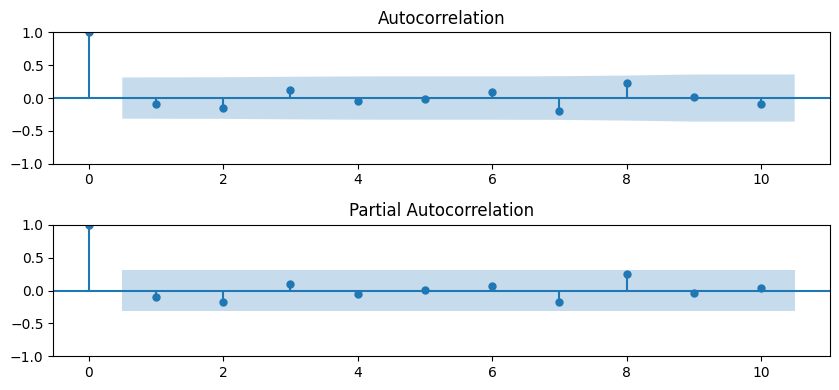

In [19]:
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')
X = series.values.astype('float32')
train_size = int(len(X) * 0.9)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
order = tuple(np.load(f'{data_path}/best_cfg.npy'))
history = [x for x in train]
months_in_year = 12
predictions = []
for t in range(len(test)):
    # transform data
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # oobservation
    obs = test[t]
    history.append(obs)
# calculate residuals
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
# summarise residuals
print(residuals.describe())
plt.figure(figsize=(10, 4))
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()
# plot acf and pacf
plot_acf_pacf(residuals, lags=10)

# Performance Boosting using Bias Corrected ARIMA Model

In [36]:
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')
X = series.values.astype('float32')
train_size = int(len(X) * 0.9)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
months_in_year = 12
predictions = []
bias = 0.400167
for t in range(len(test)):
    # transform data
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[t]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = root_mean_squared_error(test, predictions)
print('RMSE: %.3f' % rmse)
# calculate residuals
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

>Predicted=91.491, Expected=91.787
>Predicted=94.377, Expected=97.285
>Predicted=109.104, Expected=113.473
>Predicted=123.409, Expected=124.255
>Predicted=113.124, Expected=112.881
>Predicted=107.690, Expected=104.763
>Predicted=92.872, Expected=90.287
>Predicted=91.258, Expected=92.134
>Predicted=102.281, Expected=101.878
>Predicted=110.607, Expected=108.550
>Predicted=106.102, Expected=108.194
>Predicted=98.960, Expected=100.417
>Predicted=92.975, Expected=92.384
>Predicted=99.225, Expected=99.703
>Predicted=117.547, Expected=109.348
>Predicted=120.738, Expected=120.270
>Predicted=110.676, Expected=116.379
>Predicted=110.189, Expected=104.471
>Predicted=91.043, Expected=89.746
>Predicted=93.649, Expected=91.093
>Predicted=100.179, Expected=102.649
>Predicted=110.452, Expected=111.635
>Predicted=112.518, Expected=110.592
>Predicted=101.804, Expected=101.920
>Predicted=90.272, Expected=91.596
>Predicted=100.137, Expected=93.063
>Predicted=104.297, Expected=103.220
>Predicted=115.114, E

# Finalising Model and Saving model to file

Model saved successfully
Bias parameter saved successfully


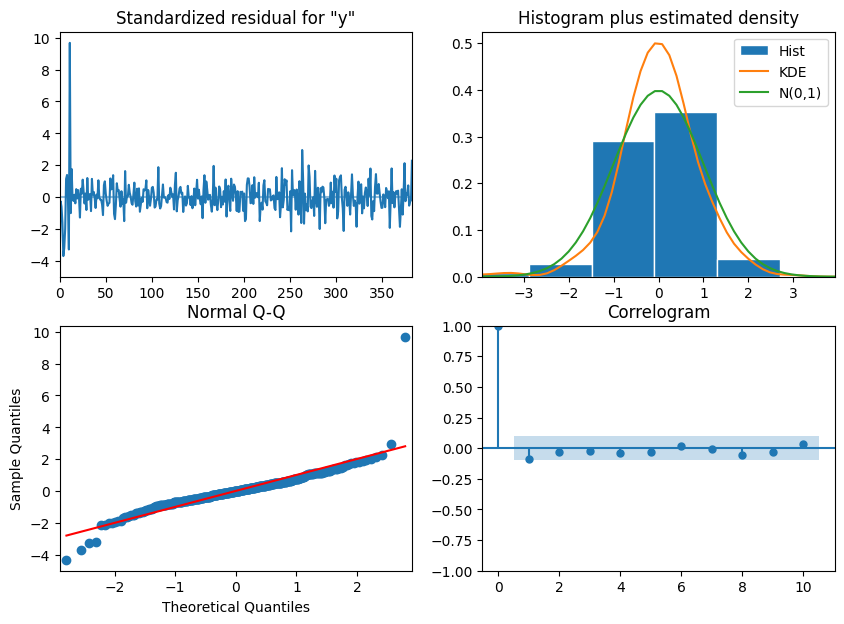

In [38]:
# load dataset
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')
X = series.values.astype('float32')

# difference data
diff = difference(X, months_in_year)

# fit model on full differenced data
model = ARIMA(diff, order=order)
model_fit = model.fit()
# plot model diagnostics
_ = model_fit.plot_diagnostics(figsize=(10, 7))
# save model
model_fit.save(f'{data_path}/electricity_forecasting_model.pkl')
print('Model saved successfully')
np.save(f'{data_path}/model_bias.npy', [bias])
print('Bias parameter saved successfully')

# Load model and Predict

In [39]:
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')
model_fit = ARIMAResults.load(f'{data_path}/electricity_forecasting_model.pkl')
print('ARIMA model successfully loaded')
bias = np.load(f'{data_path}/model_bias.npy')
print('Bias parameter successfully loaded')
# make a prediction
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

ARIMA model successfully loaded
Bias parameter successfully loaded
Predicted: 124.926


# Validate Model

>Predicted=124.926, Expected=114.851
>Predicted=102.236, Expected=99.490
>Predicted=91.062, Expected=101.040
>Predicted=94.081, Expected=88.353
>Predicted=87.470, Expected=92.080
>Predicted=107.753, Expected=102.153
>Predicted=110.366, Expected=112.154
>Predicted=112.590, Expected=108.931
>Predicted=98.661, Expected=98.615
>Predicted=92.664, Expected=93.614
>Predicted=92.162, Expected=97.336
>Predicted=116.216, Expected=114.721
>Predicted=117.971, Expected=129.405
RMSE: 6.021


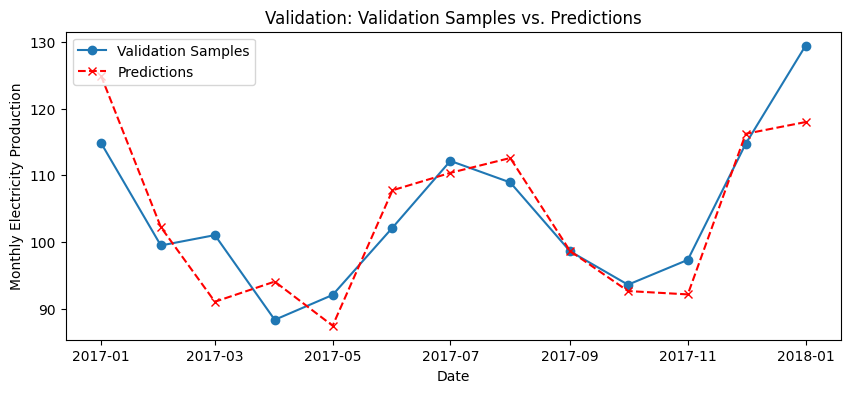

In [26]:
# load and prepare 
dataset = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')
X = dataset.values.astype('float32')
history = [x for x in X]
validation = pd.read_csv(f'{data_path}/validation.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load(f'{data_path}/electricity_forecasting_model.pkl')
bias = np.load(f'{data_path}/model_bias.npy')
order = tuple(np.load(f'{data_path}/best_cfg.npy'))

# make first prediction
predictions = []
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for t in range(1, len(y)):
    # predict
    diff = difference(history, months_in_year)
    model = ARIMA(diff, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[t]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
predictions = np.reshape(np.array(predictions), (-1, 1)).ravel()
rmse = root_mean_squared_error(y, predictions)
print('RMSE: %.3f' % rmse)
plt.figure(figsize=(10, 4))
plt.plot(validation.index, y, label='Validation Samples', marker='o')
plt.plot(validation.index, predictions, label='Predictions', color='red', linestyle='--', marker='x')
plt.title('Validation: Validation Samples vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Monthly Electricity Production')
plt.legend(loc='upper left')
plt.show()

# Where do we go from here...
In this end-to-end project, we were able to achieve remarkable performance measured by an RMSE of 3.217, which is comparable to the majority of the work presented on Kaggle for this dataset. For reference, please see https://www.kaggle.com/datasets/shenba/time-series-datasets/code. We did not experiment with power transforms such as BoxCox; perhaps that is an extension of the work that can be implemented.